Timo Haller University of Bonn, M.Sc. Economics, 16th August 2020

# Computational Statistics - Term paper

In [1]:
setwd("/Users/timohaller/Desktop/CausalForests/Project/")

library(matrixcalc)
library(foreign)
library(mvtnorm)
library(MASS)
library(sandwich)
library(lmtest)
library(ggplot2)
library(grf)
library(bindata)
library(fitdistrplus)
library(Rfast)
library(car)
library(tidyr)
#library(IRdisplay)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: survival

Loading required package: Rcpp

Loading required package: RcppZiggurat


Attaching package: ‘Rfast’


The following objects are masked from ‘package:mvtnorm’:

    dmvnorm, dmvt, rmvnorm, rmvt


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:Rfast’:

    bc




In [2]:
setwd("/Users/timohaller/Desktop/CausalForests/Project/")

source("aux/CRF function obs.R")
source("aux/CRF function noise.R")

In [3]:
### Load and clean data

setwd("/Users/timohaller/Desktop/CausalForests/Project/")

# Read in data

data <- read.csv("data/data.csv")

# Select relevant variables 

depvar <- "expec_stockret_perc_t01"
covariates <- c("high","female", "atleast_bachelor", "z_conf_prior","prior_t01","prior_squ_t01")
selection_variables <- c("housing")

data = subset(data,select=c(depvar,covariates,selection_variables))

# Rename the variables

names(data) = c("stockret", "high", "female","edu","conf","prior","prior_squ","housing")

# Select relevant observations and drop missing values

data = data[data$housing == 0,]

# Drop missing values

data =  data[complete.cases(data), ]
data$housing = NULL

## Table of contents

1. [Introduction](#introduction) 
2. [Theoretical Background about Causal Forests](#theory) 
    1. [The Roots](#theory_roots)
    2. [The Assumptions](#theory_ass)
    3. [The Setup](#theory_setup)
3. [Empirical Application](#application)     
    1. [The Survey Data](#application_data)
    2. [Estimation of Stock Return Expectations](#application_stockret)
4. [Simulation Studies](#simulation) 
    1. [General Setting](#general_setting)
    2. [Data Generating Process](#sim_dgp)
    3. [Simulation Study: Sample Size](#sim_obs)
    4. [Simulation Study: High-dimensional Data](#sim_highdim)
5. [Conclusion](#conclusion)
6. [Bibliography](#bib)

## 1. Introduction <a name="introduction"></a>

Usually, machine learning (ML) algorithms are used for prediction and not for causal inference. However, recently researchers developed methods that exploit the prediction power of ML algorithms to estimate causal effects. One example for these "new" approaches is the *causal random forest* (also *causal forest*, short: CRF) method, which was designed by Athey and Imbens (2016) and Wager and Athey (2018). The causal forest basically extends the popular *random forest* approach, which was pioneered by Breiman in 2001, in order to estimate causal effects. <br>
<br>
Traditionally, linear regression models estimated with the ordinary least squares (OLS) estimator have been the dominant tool for economists to conduct inference (see Ratkovic 2019). Under certain assumptions, linear regression models can be used to estimate causal effects. However, simple regression models typically suffer from high dependence on the model specification (see ibid.), low statistical power in small datasets and non-applicability in high-dimensional datasets.  <br> 
<br>
The following work will shed light on whether causal forests can solve the problems of the linear model and thus enrich the existing toolbox of econometricians. Therefore, I designed two simulation studies which compare the performance of causal forests with two differently specified linear models. The first simulation study will vary the number of observations and the second the number of regressors in the underlying data sample. Thereby, I use data from a randomized information experiment which was conducted by the economists Peter Maxted, Christopher Roth and Johannes Wohlfahrt in the US in 2019. It is my goal to estimate the (conditional) effect of an information treatment on people's expectations about stock returns. Note that the content and the economic interpretation of this estimation is incidental for my work. Instead, this example serves as a motivation for my simulation studies, whose data generating process (DGP) approximates the DGP of the real data. <br>
<br>
My work is structured as follows. In the next section, I will give some theoretical background information about causal forests. Since the theory of causal forests is quite complex, the section will give a more intuitive explanation on how causal forests function rather than a mathematical formulation on their asymptotic behavior. In section 3, I will explain the real data on which my simulation studies are based on. The main part of this paper is section 4, which includes the simulation studies. First, I will describe the general setting of my simulations studies and formulate the hypotheses that will be tested with the simulation studies (subsection 4.1). Afterwards, I will describe the DGP of the simulation studies which approximates the DGP of the real data (subsection 4.2). Subsequently, I will compare the performance of CRF with the linear models for varying sample sizes (subsection 4.3) and varying number of regressors (4.4). Finally, section 5 will summarize my results.    

## 2. Theoretical Background about Causal Forests <a name="theory"></a>

### 2.1 The Roots <a name="theory_roots"></a>

A Causal forest is a ML method based on the random forest algorithm of Breiman (2001) (see Wager and Athey (2018). Breiman's algorithm and subsequent procedures that build up on it are currently part of the list of most successful approaches to deal with "modern", high-dimensional datasets (see Biau and Scornet (2016)). High-dimensionality means that the number of features $p$ is (much) larger than the number of observations $n$ ($p \gg n$). Classical methods, like OLS regressions, are not applicable in these settings because they require that the number of observations is much larger than the number of regressors ($n \gg p$). Conversely, random forests can be used to regress or classify very accurately even if the data samples are small or high-dimensional (see ibid.). Roughly speaking, the method works as follows: One uses bootstrap sampling to grow $B$ regression trees and averages the predictions across all trees. Thereby, different to *bagging* or *boosting* aggregation, each tree is grown by only considering a subset of features. This decreases the correlation between trees and thus the variance of the forest becomes smaller (see James et al. (2013)). <br>
Nevertheless, random forests also have some shortcomings. First, like most machine learning algorithms, they can be only used for prediction but not for causal inference. For example, it can predict which customer group will buy a product most likely, but not how much a characteristic like for instance gender or income increases the probability of a buy. However, causal inference is usually more relevant for economists.

Furthermore, although random forests have proven their strength in many empirical applications, there exists no fundamental theory about the properties of random forests. This is because formulating the underlying theory of random forests with rigorous mathematics is very complex. Thus, theoretical results about random forests (e.g. their asymptotic behavior) have been only derived for restricted settings (see Biau and Scornet (2016)). <br>
Causal forests are designed to circumvent these limitations. They can be used to estimate heterogeneous treatment effects. Still, causal inference requires also an asymptotic theory of the causal forest estimates (see Wager and Athey (2018)). Wager and Athey (2018) show that, under certain assumptions, the causal forest estimates are consistent and asymptotically normally distributed. Hence, causal forests allow for causal inference by giving unbiased predictions for which confidence intervals can be constructed. 


### 2.2 The Assumptions <a name="theory_ass"></a>

Wager and Athey (2018) base their work on the popular Rubin outcome model (see Rubin (1974) as cited in ibid.). Assume there are $n$ observations labeled by $i$ that consist of an outcome $Y_{i}$, a binary treatment $W_{i} \in \{0,1\}$, and a feature vector $x_{i} \in X_{i}^{p}$. Define $Y_{i}^{1}$ and $Y_{i}^{0}$ as the outcome if the observation received and did not receive the treatment, respectively. Hence, the average treatment effect (ATE) is defined as follows:

$(1) \qquad \mu = E\left[Y_{i}^{1} - Y_{i}^{0} \right]$

Consequently, the ATE captures the effect of the treatment on the overall population. It is the same for all individuals independent from their characteristics. On the other hand, the conditional average treatment effect (CATE) is similarly defined but takes the characteristics of each observation into account. Hence, the CATE depends on the characteristics vector of each observation $x_{i}$. It is denoted by $\tau(x)$ and defined as follows$:^{1}$

$(2) \qquad \tau(x) = E\left[Y_{i}^{1} - Y_{i}^{0} \vert X_{i} = x_{i} \right]$

It is the goal of the causal forest to estimate $\tau(x)$. The "fundamental problem of causal inference" (Holland (1986) as cited in Athey and Imbens (2016)) is that $\mu$ and $\tau(x)$ cannot be calculated simply because for each individual only one potential outcome, i.e. either $Y_{i}^{1}$ or $Y_{i}^{0}$, can be observed. Accordingly, statistical methods for causal inference (and thus causal forests) must find a way to estimate the effect despite the fundamental problem. Therefore, usually additional assumptions are necessary. The main assumption of causal forests is "unconfoundedness", which was already used in other contexts (see Rubin and Rosenbaum (1983) as cited in ibid.). It requires the following: 

$(*) \qquad \left\{ Y_{i}^{0}, Y_{i}^{1} \right\} \perp \!\!\! \perp W_{i} \, \vert \, X_{i} \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$  (Unconfoundedness)

In words, the potential outcomes are independent from treatment assignment conditional on $X_{i}$. This ensures that treatment assignment of observations with similar characteristics $x$ is random. Hence, the assumption is always fulfilled in randomized controlled *randomized controlled trials* (RCTs). However, the unconfoundedness assumption is rather strong in observational settings. As described previously, the CRF estimate of the CATE, $\hat{\tau}(x)$, should be consistent and asymptotically normally distributed, i.e. (see Wager and Athey (2018))):

$(3) \qquad \hat{\tau}(x) - {\tau}(x) \, \big/ \, \sqrt{\text{Var}\left[\hat{\tau}(x)\right]} \xrightarrow{d} \mathcal{N}\left(0,1\right)$ 

In order to achieve this, two further assumptions must be made (see ibid.):

$(**) \qquad E\left[Y^{0} \vert X = x\right]$ and $E\left[Y^{1} \vert X = x\right]$ are Lipschitz continous. $\qquad \qquad \qquad \quad $ (Continuity) <br>
<br>
$(\textit{***}) \qquad \exists \epsilon > 0 \quad \textit{s.t.} \quad \epsilon < P \left[W = 1 \vert X = x \right] < 1 - \epsilon \quad \forall x \in X \quad \quad \,\,\, \qquad \qquad $ (Overlapping) 

The continuity assumption demands that the conditional mean functions are Lipschitz continous$.^{2}$ This is a usual assumption for the asymptotic theory of random forests (see ibid.). The overlapping condition implies that treatment assignment is not possible and not sure for any feature vector $x$. This means that e.g. in a randomized medical trial it is possible that only men receive a drug. Hence, if $n$ is large enough, for any feature vector $x$ there are enough treated and controlled observations. This is crucial for the estimation of $\tau(x)$. In order to achieve the asymptotic behavior of the estimate as formulated in (2), besides the assumptions $(*) - (\textit{***})$ a special modification of Breiman's (2001) random forest is needed (see ibid.). This leads over to the causal forest algorithm. <br>
<br>
In the following subsection I will describe the CRF algorithm according to procedure 1 in Wager and Athey (2018). In the simulation studies in section 4, I use a similar but not exactly equal version of this. It is described in Athey et al. (2019) and implemented in the <code>causal_forest</code> function of the <code>grf</code> R-package (see Athey et al. (2019) and Tibshirani (2020)). Nevertheless, I decided to present the Wager and Athey (2018) algorithm, because Athey's et al. (2019) algorithm just contains a minor extension (see Athey et al. (2019)) but is much more sophisticated and harder to explain. In the end of the next subsection I will discuss the differences between the two algorithms briefly.

### 2.3 The Setup <a name="theory_setup"></a>

A causal forest consists of $B$ individual *causal trees*. The forest aggregates the estimated effects of the individuals trees, $\hat{\tau}_{b}(x)$ for $b \in (1,...,B)$, simply by taking their average (see Wager and Athey (2018)), i.e. 

$(4) \qquad \hat{\tau}(x) = \frac{1}{B}\sum\limits_{b=1}^{B} \hat{\tau}_{b}(x)$ .  

Growing many trees instead of just one is necessary to decrease the variance of the estimates (see James et al. (2013)). <br>
Estimating $\hat{\tau}_{b}(x)$ requires to grow causal trees. This is done in two steps: First, a causal tree is built. Second, the causal effects are estimated for each *leaf* of the tree. A *tree* is a partitioning $\Pi$ of the p-dimensional future space $X^{p}$ consisting of $L$ elements $\ell$ that are called *leaves*. Formally (see Athey and Imbens (2016)):

$(5)\qquad \Pi = \left\{\ell_{1},...,\ell_{L}\right\}\quad$ with $\quad\cup_{j=1}^{L}\ell_{j} = X^{p}$

Since $\Pi$ is a partition, for each feature vector $x$ there exists a unique $\ell$ such that $x \in \ell(x;\Pi)$. Hence, for any given feature vector $x$, the estimated counterpart of $\tau(x)$ (see equation (2)) is simply the difference between the estimated average outcome of treated and untreated observations in the leaf $\ell(x;\Pi)$ where $x$ belongs to (see Wager and Athey (2018)):

$(6)\qquad \hat{\tau}_{b}(x) = \frac{1}{\vert \{ i\,:\, W_{i}\,=\,1\,,\,x_{i} \,\in\, \ell(x;\Pi) \}\vert} \sum\limits_{\{ i: W_{i}=1,x_{i} \in \ell(x;\Pi) \}} Y_{i} - \frac{1}{\vert \{ i\,:\, W_{i}\,=\,0\,,\,x_{i} \,\in\, \ell(x;\Pi) \}\vert} \sum\limits_{\{ i: W_{i}=0,x_{i} \in \ell(x;\Pi) \}} Y_{i}$

Note that there are many partitions $\Pi$ possible to split $X^{p}$. A tree algorithm must find the "best" partitioning for a given purpose. Therefore, one needs to specify a splitting criterion that decides where the splits are set. Traditional random trees like in Breiman (2001) seek to make as good predictions as possible. For this purpose, the *Classification And Regression Trees* (CART)-splitting criterion turned out to be a good choice (see Biau and Scornet (2013)). It basically chooses the partitioning in a way that the mean-squared error (MSE) of the predictions is minimized. However, the purpose of causal trees is not to predict outcomes but to estimate heterogenous treatment effects. The conventional CART criterion is not applicable for this, because unit-level causal effects $\tau_{i}$ cannot be observed (see Athey and Imbens (2016)). Instead, Athey and Imbens (2016) derived a different splitting criterion for causal trees that is adopted in the algorithm of Wager and Athey (2018). Thereby, they must assume that the tree is *honest*. A tree is honest if it uses each $Y_{i}$ in the training data either to estimate the within-leaf treatment effect $\tau$ or to decide where to place the splits of the tree, but not both (see Wager and Athey (2018)). Assuming honesty achieves that the partition is exogenously given when the treatment effects within leaves are estimated. Thus, the estimates of $\tau(x)$ are not biased. On the other hand, assuming honesty reduces the available sample which increases the variance of the estimates. Hence, there is a trade-off between bias and variance of the estimated treatment effects. However, Athey and Imbens (2016) think that the bias reduction effect dominates, particularly because unbiased estimates are needed for correct confidence intervals. This is necessary for causal inference. <br>
<br>
Wager and Athey (2018) ensure honesty as follows: For any given training sample with $N$ observation, first a random subsample of size $s < N$ is drawn. This set is further halved into two disjoint subsets (i.e. no observation is contained in both sets). Denote these sets $\mathcal{I}$ and $\mathcal{J}$ and their cardinality by $N_{\mathcal{I}} := \lfloor{s/2}\rfloor$ and $N_{\mathcal{J}} := \lceil{s/2}\rceil$$.^{3}$ Suppose that the splits are choosen by using any data from sample $\mathcal{J}$ but only $W$ and $x$ observations and not $Y$ observations from sample $\mathcal{I}$. Note that this does not mean that the sample splitting "wastes" observations. The samples $\mathcal{I}$ and $\mathcal{J}$ are newly determined for each subsample $s$. Hence, although for a single tree an observation is either used for setting the splits or predicting, for some trees each observation will participate in both sample $\mathcal{I}$ and $\mathcal{J}$ (see ibid.). <br>
Athey and Imbens (2016) derive that an appropriate splitting rule for a causal forest maximizes $-\widehat{\textit{EMSE}}_{\tau}$, which stands for the estimation of the negative expected MSE of $\tau$. Hence, the partitioning $\Pi$ must maximize the following statement (see ibid.):    

$(7) \qquad -\widehat{\textit{EMSE}}_{\tau}(\mathcal{J},N^{\mathcal{I}},\Pi) = \frac{1}{N^{\mathcal{J}}}\sum\limits_{i\in \mathcal{J}} \hat{\tau}_{b}^{2}(X_{i};\mathcal{J},\Pi) - \left(\frac{1}{N^{\mathcal{J}}} + \frac{1}{N^{\mathcal{I}}} \right) \cdot \sum\limits_{\ell \in \Pi} \left(\frac{N}{N_{treat}} S^{2}_{\mathcal{J}_{treat}}(\ell) + \frac{N}{N-N_{treat}} S^{2}_{\mathcal{J}_{control}}(\ell)\right)$ 

Thereby, $S_{\mathcal{J}_{treat}}^{2}$ and $S_{\mathcal{J}_{control}}^{2}$ are the within-leaf variances of the estimated average outcome for treated and untreated observations, respectively. The parameter $N$ is the number of training observations and $N_{treat}$ and $N_{control}$ are the number of treated and untreated observations, respectively. Note that the splitting rule only depends on sample $\mathcal{J}$ and $N^{\mathcal{I}}$ which is in accordance with the honesty condition. Equation (7) consists of two terms, where the first one is always positive and the second is always negative. The first term contains the average of the squared estimated conditional treatment effects. Accordingly, partitions that find strong heterogeneity in treatment effects are rewarded. On the other hand, the second term implies that increasing the variance of leaf estimations is penalized (see Athey and Imbens (2016)). The penalization is stronger for small sizes of $s$ and if the number of treated and untreated observations is unequal. <br>
After the best tree according to (7) was found, next the treatment effects for each leaf are estimated. This is done by simply applying equation (6) on all observations in subsample $\mathcal{I}$. Note that using observations from subsample $\mathcal{J}$ would violate the honest assumption and thus $\hat{\tau}(x)$ would be biased. <br>
<br>
There are several tuning parameters that must be set before growing a causal tree. One can identify the optimal parameters with cross-validation. One important parameter is the minimum number of observations each leaf has to contain denoted by <code>min.node.size</code>$.{4}$ It determines when the algorithm stops to split the feature space into finer leaves. Another important parameter is <code>mtry</code>. It specifies how many features are available for splitting in each tree. Like in Breiman's (2001) random forests, it can make sense to limit the features in the tree-building phase to decorrelate the trees and thus to achieve more precise predictions. <br>
As mentioned previously, in the simulation studies I use a CRF algorithm that is not exactly equal to the one I described above. The <code>causal_forest</code> function of the <code>grf</code> package uses an approximated gradient-based loss criterion which is more computationally efficient. Furthermore, it applies a special weighting scheme to aggregate the predictions of the trees instead of just taking their average as in equation (4).  
In combination with the more flexible form of generalized random forests, this makes the <code>grf</code> version better in terms of dealing with violations against the unconfoundedness condition and treatment heterogeneity$.^{5}$ (see Athey et al. (2019))

___
$^{1}$ Note that by the law of iterated expectations the following holds: $\mu = E\left[E\left[Y_{i}^{1} - Y_{i}^{0} \vert X_{i} = x_{i} \right]\right] = E\left[\tau(x)\right]$ <br>
$^{2}$ Lipschitz continuity is more stringent than the common continuity definition. It requires that the rate of change of a function is bounded.    
$^{3}$ The floor and ceiling function ensure that the size of sets $\mathcal{I}$ and $\mathcal{J}$ are always integers, even if $s$ is odd. <br>
$^{4}$ I use the notation from the R-package <code>grf</code> here (see Tibshirani (2020)). <br>
$^{5}$ Check Athey et al. (2019) for a comparison between the different causal forests algortihms under these circumstances. 

## 3.  Empirical Application <a name="application"></a>

### 3.1 The Survey Data <a name="application_data"></a>

In my simulation studies, I estimate the ATE and CATE of an information treatment on people's long-term expectations of stock returns. Therefore, I use survey data from an experiment which was conducted by Peter Maxted, Christopher Roth and Johannes Wohlfahrt in the US in 2019. The goal of the experiment is to study the effect of long-term asset expectations on short-term consumption. The evaluation of the survey is not published yet. I have access to the data because I work as a student research assistant for Christopher Roth at the *briq - Institute on Behavior & Inequality* in Bonn. I am very thankful that the researchers allowed me to use the data for this project. <br>
<br>
The original dataset contains online survey data from 8,247 respondents. The people were randomly divided into four similarly sized treatment groups. Two groups were treated with a short text that contains a forecast about the long-term development of US stock returns. The other two groups received a similar information treatment about house prices. In my analysis, I only consider the 4,138 observations with the stock return treatment. These observations are further split randomly into two similarly sized groups. One group received a very optimistic forecast which expects the average annual return of US stocks to be 10 % per year over the next 10 years. The other group received a similar but less optimistic forecast which estimates the average annual return to be 2 %. The exact wording of the optimistic information treatment is as follows: 

___
*We now would like to provide you with a forecast of stock returns from an expert who regularly participates in the World Economic Survey, an expert survey on macroeconomic forecasts. According to this expert forecast, the average annual return of the US stock market over the next ten years will be 10 percent. In the case where stock returns are 10 percent in each of the next ten years, this would mean that someone who invests 100,000 Dollar today in a portfolio that holds all stocks listed on the US stock market will own about 259,375 Dollar in ten years from now.*
___

The pessimistic treatment is almost equal, despite that 10 % is replaced by 2 % and 259,375 Dollar by 121,899 Dollar. I define the dummy variable *high* as the treatment variable. If its value is one, the person received the optimistic forecast from above (treatment group) and if it is zero, the person received the pessimistic forecast (control group). Note that the treatment was randomly assigned by experimental design. The treatment so to say shifts peoples' expectations about their assets exogeneously and hence it is possible to study the causal effect of expectations on different outcomes. In particular, it is possible to apply CRF in this setting because the unconfoundedness condition is met and the treatment variable is binary.<br>
I want to examine whether people who received the optimistic forecast indeed expect a higher annual return of the US stock market over the next ten years. The outcome variable *stockret* contains the respective answers. The respondents could state any estimate between -100 % and <nobr> 100 $\%^{1}$ </nobr> with up to two decimal places. In the following subsection I will build up a simple but profound linear model which uses the treatment variable *high* in combination with further covariates to explain the outcome variable *stockret*.

### 3.2 Estimation of Stock Return Expectations <a name="application_stockret"></a>

The effect of the treatment on the outcome is expected to be positive. However, one has to expect that the treatment effect varies for different subgroups of people. For example, it may be the case that one gender is more sensitive in adjusting its stock return expectations after receiving the treatment. The same could be the case for educated and less educated persons. Very important is also to consider peoples' expectations on how stock returns develop *before* they were confronted with the information treatments. Hence, further covariates are needed to consider potential effect heterogeneity. Fortunately, the survey collected a lot of information about other beliefs and demographic characteristics of the respondents. The dummy *female* indicates whether a person is a woman. Another dummy denoted by *edu* flags persons that hold a bachelor's or higher degree. The variable *prior*  measures peoples' stock return expectations before they received the treatment. It contains the answer to a question that is very similar to the one of the outcome *stockret*. Again, the answers were allowed to be between <nobr>-100 %</nobr> and <nobr> 100 % </nobr> with up to two decimal places. Additionally, the categorical variable *conf* measures how confident people are about their prior expectation. The persons could select one out of the five following answers: *Extremely confident*, *Very confident*, *Somewhat confident*, *Not very confident*, and *Not at all confident*. Since the interpretation of this scale is subjective, the answers were z-transformed (normalized) into a standard normal distributed variable. <br>
<br>
In a next step, I regress *stockret* on the treatment variable and the other covariates. Note that usually the specification of an econometric model should be based on economic theory. Otherwise the estimated coefficients cannot be interpreted meaningfully. However, in our case the interpretation of the coefficients is incidental. The prediction model will be used as a blueprint for the DGP of the simulation studies in section 4. It must not "tell a story" about how each variable affects the outcome. Instead, it has to fit the data well and must be somehow complex. It turned out that the following model is suitable for our purpose:

$(8) \qquad \textit{stockret} = \hat{\beta}_{0} + \hat{\beta}_{1} \, \textit{high} + \hat{\beta}_{2} \, \textit{female} + \hat{\beta}_{3} \, \textit{edu} + \hat{\beta}_{4} \, \textit{prior} + \hat{\beta}_{5} \, \textit{prior_squ} + \hat{\beta}_{6} \, \textit{conf} + \hat{\beta}_{7} \, {high} \times \, \textit{female} + \hat{\beta}_{8} \, {high} \times \, {edu} + \hat{\beta}_{9} \, {high} \times \, {prior} + \hat{\beta}_{10} \, {high} \times \, {prior\_squ} + \hat{\beta}_{11} \, {high} \times \, \textit{conf} + \hat{\beta}_{12} \, \textit{edu} \times \, \textit{conf} + \hat{\beta}_{13} \, \textit{high} \times \textit{edu} \times \textit{conf} + \hat{\beta}_{14} \, \textit{prior} \times \textit{prior_squ} + \hat{\beta}_{15} \, \textit{high} \times \textit{prior} \times \textit{prior_squ} + \epsilon$ 

whereby $\epsilon$ denotes the idiosyncratic error term. Note that the variable index is left out for readibility, because the data are crosssectional. For readability, one can rewrite equation (8) as follows:

$(8*) \qquad stockret = \hat{\beta}_{0} + \textit{high}\,\#\#\,\textit{female} + \textit{high}\,\#\#\,\textit{edu}\,\#\#\,\textit{conf} + \textit{high}\,\#\#\,\textit{prior}\,\#\#\,\textit{prior_squ} + \epsilon$ 

whereby $\,\#\#\,$ stands for imputing the variables and all their interactions with each other$.^{1}$ Hence, *female* is one-way interacted with *high*. Moreover, *high* has two two-way interactions with both *edu* and *conf* as well as with *prior* and *prior_squ*, respectively. Note that $\textit{prior} \,\#\#\, \textit{prior_squ}$ basically means that a cubic version of *prior* and its interaction with *high* is added to the model (see equation (8)). The following cell estimates the model with OLS. 

In [4]:
# Generate interactions

high_female = data$high * data$female 
high_edu = data$high * data$edu
high_prior = data$high * data$prior
high_prior_squ = data$high * data$prior_squ
high_conf = data$high * data$conf
edu_conf = data$edu * data$conf
high_edu_conf = data$high * data$edu * data$conf 
prior_prior_squ = data$prior * data$prior_squ
high_prior_prior_squ = data$high * data$prior * data$prior_squ

data_reg = cbind(data,high_female,high_edu,high_prior,high_prior_squ,high_conf,edu_conf,high_edu_conf,prior_prior_squ,high_prior_prior_squ)

fit = lm(data=data_reg,formula="stockret ~ high + female + edu + prior + prior_squ + conf + high_female + high_edu + high_prior + high_prior_squ + high_conf + edu_conf + high_edu_conf + prior_prior_squ + high_prior_prior_squ")
#summary(fit)
coeftest(fit, vcov = vcovHC(fit, "HC1"))

###
print("Number of observations")
dim(data_reg)[1]
print("Sum of squared residuals")
round(sum((fit$residuals)^2))
print("Adjusted R-squared")
round(summary(fit)$adj.r.squared,3)


t test of coefficients:

                        Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)           3.5243e+00  2.8531e-01 12.3528 < 2.2e-16 ***
high                  1.7132e+00  4.1540e-01  4.1243 3.796e-05 ***
female               -5.1176e-01  2.4506e-01 -2.0883 0.0368333 *  
edu                   2.7862e-01  2.4618e-01  1.1318 0.2577993    
prior                 1.5518e-01  4.8828e-02  3.1782 0.0014937 ** 
prior_squ             9.4570e-04  2.3898e-03  0.3957 0.6923287    
conf                 -5.3260e-01  1.8250e-01 -2.9183 0.0035391 ** 
high_female           7.9010e-01  3.4858e-01  2.2666 0.0234694 *  
high_edu             -8.8328e-01  3.3116e-01 -2.6672 0.0076795 ** 
high_prior            2.9567e-01  7.2841e-02  4.0590 5.023e-05 ***
high_prior_squ       -1.3060e-02  3.7600e-03 -3.4732 0.0005197 ***
high_conf             2.9793e-01  2.4375e-01  1.2223 0.2216784    
edu_conf             -4.8809e-01  2.3588e-01 -2.0693 0.0385873 *  
high_edu_conf         7.7908e-01  3.

[1] "Number of observations"


[1] 3948

[1] "Sum of squared residuals"


[1] 77163

[1] "Adjusted R-squared"


[1] 0.202

Rounding the coefficients for convenience gives us the following model: 

$(9) \qquad \widehat{\textit{stockret}} = 3.5 + 1.7 \, \textit{high} - 0.5 \, \textit{female} + 0.3 \, \textit{edu} + 0.15 \, \textit{prior} - 0.5 \, \textit{conf} + 0.001 \, \textit{prior_squ}  + 0.8 \, {high} \times \, \textit{female} - 0.9 \, {high} \times \, {edu} + 0.3 \, {high} \times \, {prior} - 0.013 \, {high} \times \, {prior\_squ} - 0.5 \,\textit{edu} \times \, \textit{conf} + 0.3 \, {high} \times \, \textit{conf} + 0.8 \, \textit{high} \times \textit{edu} \times \textit{conf} - 0.000037 \, \textit{prior} \times \textit{prior_squ} + 0.000139 \, \textit{high} \times \textit{prior} \times \textit{prior_squ} + \epsilon$ 

Most coefficients are estimated precisely at the 1 % and 5 % significance level, respectively. On the other hand, the coefficients of *edu*, *prior_squ*, *high_conf* and *prior_prior_squ* are not significant. Also, the adjusted R-squared is not large (0.2). Hence, the model's ability to explain the real data is limited. Still, I use it as the *true model* to explain *stockret* in the simulation studies in section 4. 

___
$^{1}$ e.g. $\textit{high}\,\#\#\,\textit{female} = \hat{\beta}_{1} \, \textit{high} + \hat{\beta}_{2} \,\textit{female} + \hat{\beta}_{3} \, \textit{high} \times \textit{female}$


## 4. Simulation Studies <a name="simulation"></a>

### 4.1 General Setting <a name="general_setting"></a>

The simulation studies are conducted to get insights under which circumstances one should prefer CRF or an OLS estimated linear model. Therefore, in subsection 4.3 I will vary the number of observations $n$. This will shed light on how the models perform if the available dataset is small and large, respectively. In subsection 4.4, I will vary the dimension of the feature space $p$ through adding additional noise variables. <br>
I compare the CRF with two different versions of the linear model. The first linear model estimates *stockret* according to its real specification as stated in equation (9). I refer to this model as *complex model*. In contrast to this, the second *simple model* estimates *stockret* by just considering the first order interactions. Accordingly, it estimates the following equation:

$(10) \qquad \textit{stockret} = \beta_{0} + \beta_{1} \, \textit{high} + \beta_{2} \, \textit{female} + \beta_{3} \, \textit{edu} + \beta_{4} \, \textit{prior} + \beta_{5} \, \textit{conf} + \beta_{6} \, \textit{prior_squ}  + \beta_{7} \, {high} \times \, \textit{female} + \beta_{8} \, {high} \times \, {edu}$ <br> $\qquad \qquad \qquad \qquad + \,\beta_{9} \, {high} \times \, {prior} + \beta_{10} \, {high} \times \, {prior\_squ} + \epsilon$ 

Hence, it ignores some of the interaction terms that determine the treatment effect heterogeneity. The motivation for this model comes from practice. Oftentimes, researchers check for treatment heterogeneity only with one-way interactions. Thus, it can happen that some important heterogeneity effects are missed due to model misspecification (see Ratkovic (2019)). Causal forests do not suffer this problem, because they do not rely on a specification. Forming expectations about the behavior of the linear models in the simulation studies, it is useful to recall the OLS estimator and its properties. The OLS estimator for $n$ observations and $p$ covariates is given as follows (see Wooldridge (2013)):

$(11) \qquad \hat{\mathbf{\beta}} = \left(\mathbf{X^{\top}}\mathbf{X}\right)^{-1}\mathbf{X^{\top}}\mathbf{Y}$

whereby $\mathbf{X}_{n\times p+1}$ is the design matrix and $\mathbf{Y}_{n\times 1}$ the outcome vector. Equation (11) implicitly implies that the estimator is only unique if the inverse $\left(\mathbf{X^{\top}}\mathbf{X}\right)^{-1}$ exists. This requires that $\mathbf{X}$ is not multicollinear, i.e. that it has independent columns. This can never be the case if $p+1 > n$. Even in the case with slightly fewer independent variables than covariates <nobr>($p+1 < n$ and $p+1 \approx n$)</nobr>, the estimates can become very bad due to imperfect multicollinearity. As a consequence, the linear model requires that the number of observations is much larger than the number of independent variables ($p+1 \ll n$). However, if this assumption is met and the linear model is specified correctly, the asymptotic theory of the OLS estimator indicates that $\hat{\mathbf{\beta}}$ is unbiased for large $n$. Note that both the *complex* and *simple* model are correctly specified, because both do not omit any relevant variables. Accordingly, the estimated ATE is expected to be unbiased in both models. Since the *simple* model does not capture the whole treatment effect heterogeneity, its estimated CATE $\tau(x)$ (see equation (2)) will be incorrect though. <br>
In contrast to OLS estimation, according to Biau and Scornet (2016) random forests can deal with high-dimensional data very well. Since causal forests are an extension of random forests (see Wager and Athey (2018)), it seems obvious that they also should outperform the linear model whenever the number of dimensions is large. On the other hand, the linear model may be more accurate than causal forests for low-dimensional data with many observations. This is because in our example the true *stockret* depends linearly on the covariates (see equation (9)). The linear model is designed for capturing linear relationships, whereas causal forest as a tree-based method is not (see James et al. (2013)). <br>
<br>
Summing up, the simulation studies will verify the following hypotheses:

1. CRF will perform better than the linear models for small sample sizes.
2. In low-dimensional data samples with large $n$, the complex linear model will outperform CRF.
3. In any setting, CRF will be better in estimating the CATEs than the misspecified simple model.
4. Linear models cannot be used for high-dimensional data $\left(p+1 > n\right)$. For $p+1 < n$ and $p+1 \approx n$ they will perform very bad. 
5. CRF can be used for high-dimensional data. However, the preciseness of its estimates will also decrease by adding more covariates.


<br>
In the subsequent simulation studies, each simulation is repeated $m$ times (the default of $m$ is 50). The simulations are indexed by $i$. I compare the models based on two key figures. The first one, $\widehat{\textit{EMSE}}_{\tau}$, is the estimated expected MSE of the CATE (see equation (2)):

$(12) \qquad \widehat{\textit{EMSE}}_{\tau} = \frac{1}{m} \, \sum\limits_{i=1}^{m} \frac{1}{n}\left(\hat{\tau}_{i}(x) - \tau_{i}(x)\right)^{2}$


Analogously, $\widehat{\textit{EMSE}}_{\mu}$ denotes the estimated expected MSE of the ATE:

$(13) \qquad \widehat{\textit{EMSE}}_{\mu} = \frac{1}{m} \, \sum\limits_{i=1}^{m} \frac{1}{n}\left(\hat{\mu}_{i} - \mu_{i}\right)^{2}$

This means, for each simulation the average squared difference between the estimated and true $\tau(x)$ and $\mu$, respectively, is calculated and afterwards averaged over all simulations. Note that this is possible because in simulation studies the true ATE and CATE are known. Furthermore, for each EMSE, smaller values indicate a better fit of the underlying model.    

### 4.2 Data Generating Process <a name="sim_dgp"></a>

In subsection 3.2, I estimated the relationship between *stockret* and the covariates. Equation (9) is used to model the true values of *stockret*. In a next step, it is necessary to specify the distribution of the independent variables. Thereby, it is also important to take the correlation structure between covariates into account. The distributions of the simulated variables should be close to the distributions of their real counterparts. Since the DGP of real data usually is very complex, it is only possible to approximate it strongly simplified. <br>
The following table gives some summary statistics of the relevant real variables. Afterwards, I go through all relevant variables and explain how I generated them.

**Table 1 - Summary Statistics of Variables** 

In [5]:
data_stats = subset(data,select=-c(stockret,prior_squ))

quantiles = data.frame(t(apply(data_stats,2,quantile)))
names(quantiles) = c("Min","Q25","Median","Q75","Max")

sumstats = cbind(Type = c("Dummy","Dummy","Dummy","Categorical","Continous"), round(cbind(data.frame(Mean=colMeans(data_stats), SD = apply(data_stats,2, sd)),quantiles),digits=3))
sumstats

,Type,Mean,SD,Min,Q25,Median,Q75,Max
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high,Dummy,0.502,0.500,0.000,0.000,1.000,1.000,1.000
female,Dummy,0.778,0.416,0.000,1.000,1.000,1.000,1.000
edu,Dummy,0.473,0.499,0.000,0.000,0.000,1.000,1.000
conf,Categorical,0.408,0.960,-1.833,-0.096,0.772,0.772,1.641
prior,Continous,8.503,9.882,0.000,3.000,5.000,10.000,87.000


**high** <br>
The treatment dummy *high* was randomly assigned to the individuals with probability one half. Thus, *high* is independent from all other covariates. This implies that *high* is not correlated with any other covariate. Accordingly, it is obvious to draw its simulated counterpart from a univariate binomial distribution with probability one half.

In [6]:
set.seed(123)
N = 10000

sim_high = data.frame(high = rbinom(n = N, prob=0.5,size=1))

**female, edu and conf** <br>
Like *high*, also variables *female*, *edu* and *conf* are discrete variables. In contrast, these variables are not independent from each other. Hence, it would be inappropriate to ignore possible correlations and draw each of them from a univariate distribution. The following correlation matrix will give some insights about the correlation structure of the real variables:

In [7]:
cor(subset(data,select=c("female","edu","conf")))

,female,edu,conf
female,1.0000000,0.18907979,0.24078416
edu,0.1890798,1.00000000,0.03498882
conf,0.2407842,0.03498882,1.00000000


The variable *female* is correlated positively with both *edu* and *conf*. Furthermore, it seems that there is no correlation between *edu* and *conf*. To investigate this issue further, it is useful to estimate two regression models. First, one regresses *female* on *edu* and *conf* with a logit model. Both coefficients should be significant. Second, one estimates an ordinal logistic regression model with *conf* as outcome and *female* and *edu* as independent variables. In this model, *female* should have a positive coefficient while *edu* has not. The results of these two regressions are as follows:   

In [8]:
data$conf_new = as.factor(data$conf)

female_fit = glm(data,formula = "female ~ edu + conf",family=binomial(link="logit"))
conf_fit = polr(data,formula="conf_new ~ female + edu")

print("Regression 1: female on edu and conf (Logit)")
coeftest(female_fit)

print("Regression 2: conf on edu and female (Ordinal Logistic Regression)")
coeftest(conf_fit)

[1] "Regression 1: female on edu and conf (Logit)"



z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
(Intercept) 0.700846   0.050323  13.927 < 2.2e-16 ***
edu         0.964693   0.084607  11.402 < 2.2e-16 ***
conf        0.601168   0.041796  14.383 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] "Regression 2: conf on edu and female (Ordinal Logistic Regression)"



Re-fitting to get Hessian





t test of coefficients:

        Estimate Std. Error t value Pr(>|t|)    
female  1.141459   0.071645 15.9321   <2e-16 ***
edu    -0.089801   0.058784 -1.5276   0.1267    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Indeed, the estimated coefficients are as expected. The variable *female* is explained by both *edu* and *conf*, while *conf* is not explained by *edu*. Hence, it is reasonable to draw the simulated variables of *female* and *edu* from a correlated binomial distribution. This is done by using the function <code>rmvbin</code> from the <code>bindata</code> package. Thereby, one has to specify the probabilities that *female*, *edu* and both *female* and *edu* are one. These are stored in a matrix called *commprob* and can be easily derived from the real data (see below). In a next step, the simulated values of *conf* are drawn under consideration of the correlation with *female*. This is done by drawing *conf* from a multivariate binomial distribution, whereby the probabilities of each category depend on the level of *female*. The conditional probabilities (stored in vectors *prob_male* and *prob_female*) are again estimated from the real data.  

In [9]:
N = 10000

### Draw female and edu variables

table_female_edu = table(data$female,data$edu,dnn = c("female","edu"))
mprob = c(sum(data$female)/dim(data)[1],sum(data$edu)/dim(data)[1])
commprob = matrix(c(sum(data$female)/dim(data)[1],dim(data[data$female == 1 & data$edu == 1,])[1]/dim(data)[1]
,dim(data[data$female == 1 & data$edu == 1,])[1]/dim(data)[1],sum(data$edu)/dim(data)[1]),nrow=2,ncol=2)


sim_fem_edu_conf = data.frame(rmvbin(n=N,margprob=as.matrix(mprob),commonprob=commprob))
names(sim_fem_edu_conf) = c("female","edu")

### Draw conf variable 

prob_male = c(data.frame(table(data[data$female == 0,]$conf)/length(data[data$female == 0,]$conf))$Freq)
prob_female = c(data.frame(table(data[data$female == 1,]$conf)/length(data[data$female == 1,]$conf))$Freq)

cat_vector = cat_vector = as.numeric(names(table(data[data$female == 0,]$conf)))

sim_fem_edu_conf$conf = NA

for (i in seq(1,N,1)) {
    
  if (sim_fem_edu_conf[i,]$female == 0) {
    
    sim_fem_edu_conf[i,]$conf = sum(rmultinom(n=1,size=1,prob=prob_male)*cat_vector)
  }
  else {
    
    sim_fem_edu_conf[i,]$conf = sum(rmultinom(n=1,size=1,prob=prob_female)*cat_vector)
  }
}

**prior** <br>
The variable *prior* is the only continous variable in the dataset. Thus, the simulated version of *prior* must follow a continous distribution which is close to the real distribution. In doing so, first one has to find an appropriate distribution function. Subsequently, one must find the correct distribution parameters to match the real distribution as good as possible. <br>
By design of the survey, possible values of *prior* are between -100 % and 100 %. However, most people did not state extreme expectations, especially not in the negative range. Furthermore, the we use a trimmed version of the initial variable at the 1% level. This means the top and bottom percentile was dropped. As a consequence, in our data *prior* ranges between 0 % and 87 %, with mean at 8.5 % and median at 5 % (see Table 1). Thus, a continous distribution function that is defined for non-negative values only is supposed too be a good choice. The following histogram of *prior* helps to get a better idea about how *prior* is distributed:

**Figure 1 - Histogram of prior**

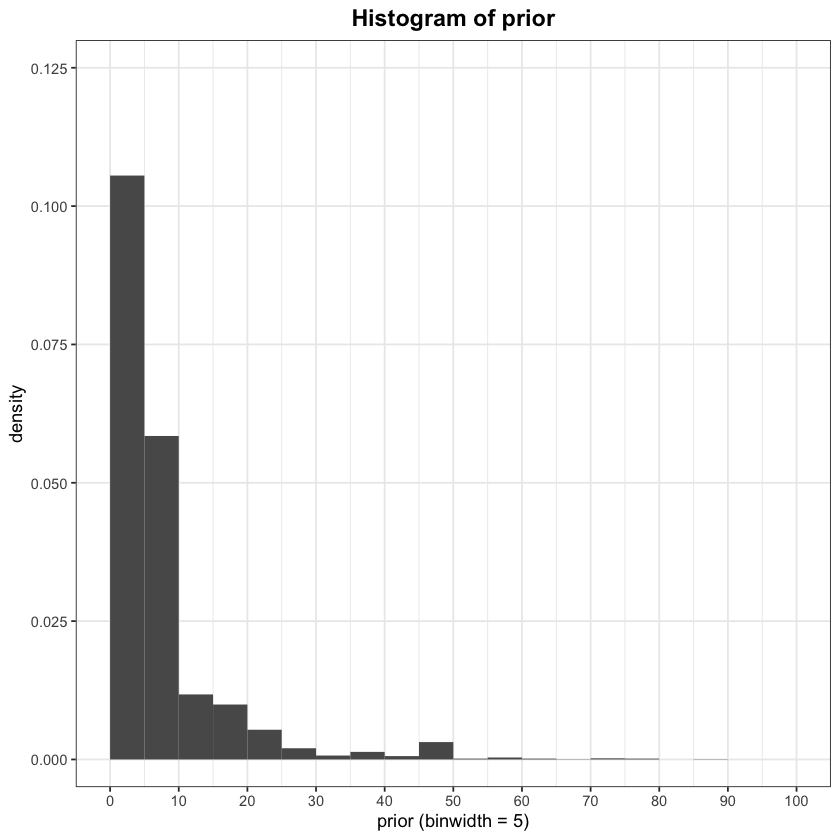

In [10]:
ggplot() + 
    theme_bw() +
    geom_histogram(data=data,aes(x=prior,y=..density..),binwidth=5,color="white",size=0,boundary=0) +
    scale_x_continuous(minor_breaks = seq(0 , 100, 5),breaks=seq(0,100,10),lim=(c(0,100)),,expand=c(0,5)) +
    scale_y_continuous(minor_breaks = seq(0 , 0.1, 0.025),breaks=seq(0 , 0.125, 0.025),lim=(c(0,0.125)),expand=c(0,0.005)) +
    labs(x="prior (binwidth = 5)") + 
    ggtitle("Histogram of prior") +  
    theme(plot.title=element_text(size=14,face="bold",hjust=0.5))

The histogram shows that the vast majority of people (about 82 %) expected an annual stock return between 0 % and 10 % inclusively. Still, there is also a considerable amount of expectations between 10 % and 50 %. Very few people expect an annual stock return of more than 50 %. There are many distributions that may fit the data well, for example the Weibull, gamma, log-normal and exponential distribution **(see McLaughlin 1999)**. However, besides the exponential distribution, they can not estimated with maximum likelihood estimation (MLE) because *prior* contains zero values for which they are not defined$.^{1}$ Hence, I decided to assume a exponential distribution and estimate its *rate* parameter $\lambda$ with MLE. 

**Figure 2 - MLE Estimation of prior** 

Fitting of the distribution ' exp ' by maximum likelihood 
Parameters:
      estimate  Std. Error
rate 0.1176085 0.001871625

[1] "Log-likelihood of MLE fit"


[1] -12398

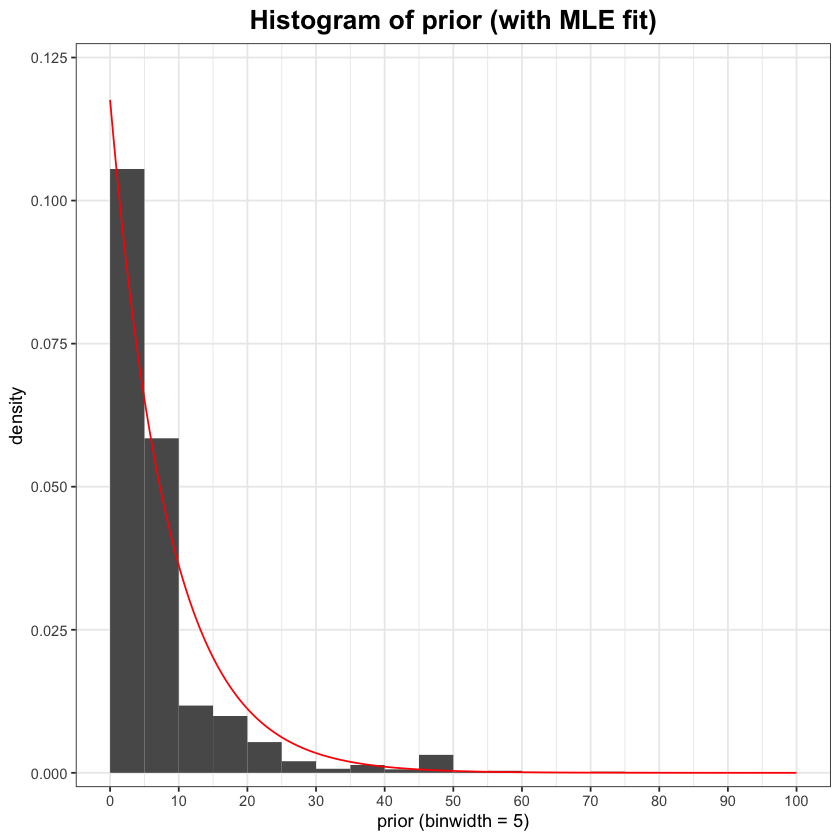

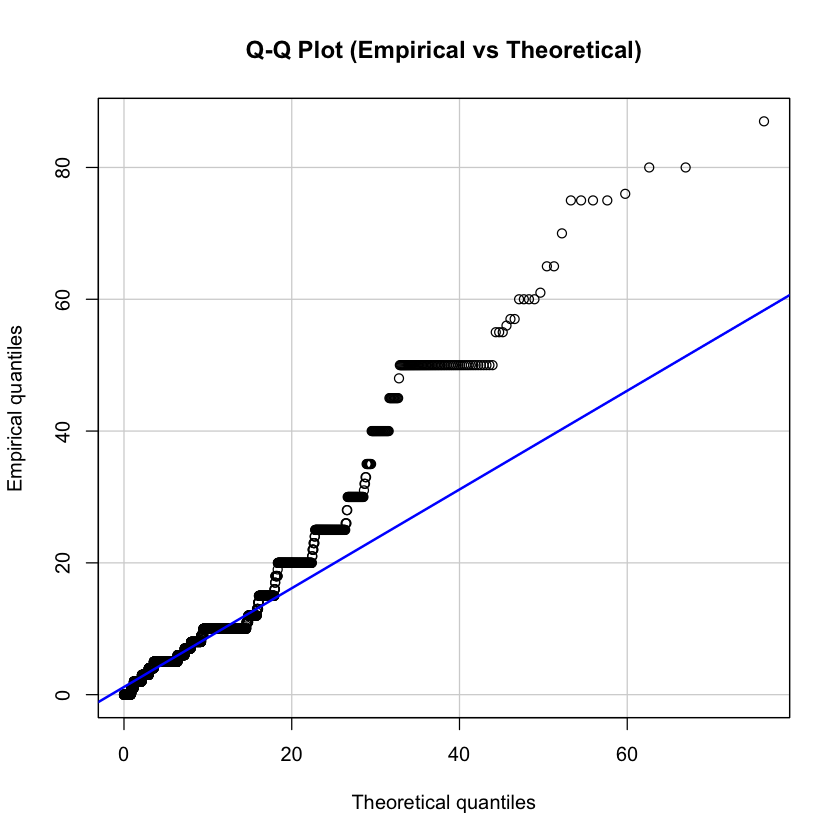

In [11]:
### MLE estimation of prior (assuming exponential distribution)

exp_fit <- fitdist(data$prior, "exp")
exp_fit
print("Log-likelihood of MLE fit")
round(exp_fit$loglik)

exp_fit_density <- data.frame(x=seq(0,100,0.1),density=dexp(seq(0,100,0.1),rate=exp_fit$estimate))

ggplot() + 
    theme_bw() +
    geom_histogram(data=data,aes(x=prior,y=..density..),binwidth=5,color="white",size=0,boundary=0) +
    geom_line(data=exp_fit_density,aes(x=x,y=density),color="red") +
    scale_x_continuous(minor_breaks = seq(0 , 100, 5),breaks=seq(0,100,10),lim=(c(0,100))) +
    scale_y_continuous(minor_breaks = seq(0 , 0.1, 0.025),breaks=seq(0 , 0.125, 0.025),lim=(c(0,0.125)),expand=c(0,0.0025)) +
    labs(x="prior (binwidth = 5)") + 
    ggtitle("Histogram of prior (with MLE fit)") +  
    theme(plot.title=element_text(size=16,face="bold",hjust=0.5))

qqPlot(data$prior, distribution="exp",rate=exp_fit$estimate,envelope=FALSE,id=FALSE,main="Q-Q Plot (Empirical vs Theoretical)",ylab="Empirical quantiles",xlab="Theoretical quantiles",line="quartiles")

The maximum likelihood estimate for the rate parameter is about *0.1176*. **Figure 2** additionally shows some diagnostic plots assessing the goodness of fit of the estimated exponential distribution. The top graph compares the density of the empirical distribution of prior (grey histogram bars) and its estimated counterpart (red line). The estimation fits the empirical distribution well for small values below 10 \%. However, it overestimates the number of values between 10 \% and 10 \% and underestimates the number of values above 40 \%. This is especially due to an accumulation of *prior* values at 50 \%. The bottom quantile-to-quantile (Q-Q) plot further emphasizes this. For small values, the empirical and theoretical quartiles are almost equal indicated by the scatterpoints being close to the blue reference line. However, the staircase form of the graph points out that there are accumulations (e.g. at 5 \%, 10 \% and 20 \%) which can not be captured by the estimated distribution. This is especially severe at 50 \%, where much more observations are located than expected. Furthermore, large values occur much more often than predicted. <br>
In the following cell, the simulated *prior* values are drawn and concatenated with the other simulated variables. Furthermore, Table 2 shows summary statistics of the simulated variables which can be compared to those of the original variable as summarized in Table 1. In the next section, the simualted data will be used in the simulation studies.  

**Table 2 - Summary Statistics of Simulated Variables**

In [12]:
### Draw prior from MLE estimated exponential distribution

sim_prior = rexp(n=10000,rate=exp_fit$estimate)

### Create combined simulated dataset

data_sim = cbind(sim_high,sim_fem_edu_conf,sim_prior)

### Create summary statistics of simulated data

quantiles = data.frame(t(apply(data_sim,2,quantile)))
names(quantiles) = c("Min","Q25","Median","Q75","Max")

sumstats_sim = cbind(Type = c("Dummy","Dummy","Dummy","Categorical","Continous"), round(cbind(data.frame(Mean=colMeans(data_sim), SD = apply(data_sim,2, sd)),quantiles),digits=3))
sumstats_sim

,Type,Mean,SD,Min,Q25,Median,Q75,Max
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high,Dummy,0.494,0.500,0.000,0.000,0.000,1.000,1.000
female,Dummy,0.776,0.417,0.000,1.000,1.000,1.000,1.000
edu,Dummy,0.469,0.499,0.000,0.000,0.000,1.000,1.000
conf,Categorical,0.406,0.966,-1.833,-0.096,0.772,0.772,1.641
sim_prior,Continous,8.325,8.125,0.000,2.387,5.790,11.647,70.671


___

$^{2}$ One could also estimate the Weibull, gamma and log-normal distribution with MLE by using a slightly modified version of *prior* which replaces zero values by a small number. However, the maximum likelihood estimates heavily depend on how exactly *prior* is defined and are thus somehow arbitrary.

### 4.3 Simulation Study: Sample Size <a name="sim_obs"></a>

The simulation study for varying the number of observations is conducted with the functions <code>crf_sim_obs</code> (for causal forest) and <code>ols_sim_obs</code> (for linear model). Both functions have a similar set up and can be adjusted with the same parameters. In each simulation, firstly the models are estimated with a training sample. Subsequently, the obtained estimates are used to predict the observations in a test data set. The training and test samples are independent from each other and have the same size $n$. Thereby, the sample size is varied across simulations. The number of observations for which the simulations are run are specified in a vector in the argument of the <code>n</code> parameter. For a given sample size, each simulation is repeated as many times as specified with the <code>m</code> parameter. The parameter <code>dgp_complex</code> takes a boolean expression and its default value is <code>TRUE</code>. If it is set to <code>TRUE</code>, the underlying DGP is as described in the previous section. In particular, it captures the correlation structure between *female*,*edu* and *conf*. If it is set to <code>FALSE</code>, the correlation between variables is ignored and they are all independent from each other. This simplification of the DGP can make sense in order to decrease the required time for computation. <br> 

It was not possible to set $n$ considerably lower than 100, because for fewer observations the <code>causal_forest</code> function does not work. It is of course possible to run the simulation study for more than 10,000 observations. However, this increases computation time (especially for causal forests) tremendously. Especially the CRF estimation is very computationally intensive. This is also the reason why I decided not to tune the parameters of the <code>causal_forest</code> function with cross-validation. In all of my simulation studies, I set $m$ to 50. The subsequent cells will conduct the first simulation study and will summarize its results. Note that the random seeds are choosen in a way that each model is estimated for the same random sample.

In [13]:
### Simulation Study: Number of observations

# Causal random forests
set.seed(123)
results_obs_crf = crf_sim_obs(n=c(100,200,500,1000,2000,4000,8000,10000),m=50,dgp_complex=TRUE,parameter_tuning=FALSE)

results_obs_crf = round(results_obs_crf,3)


100

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

200

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

500

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

1000

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

2000

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

4000

1

2

3

4



In [14]:
# Linear model 

set.seed(123)
results_obs_ols = ols_sim_obs(n=c(100,200,500,1000,2000,4000,8000,10000),m=50,dgp_complex=TRUE)

results_obs_ols = round(results_obs_ols,3)


100

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

200

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

500

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

1000

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

2000

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

4000

1

2

3

4



**Table 3 - Results of Simulation Study 1**

In [15]:
### Table with CATE EMSE results for different observations

Table_CATE_obs = rbind(results_obs_crf[c("EMSE_CATE_crf","MSE_CATE_crf_sd"),],results_obs_ols[c("EMSE_CATE_simple","MSE_CATE_simple_sd","EMSE_CATE_complex","MSE_CATE_complex_sd"),])
Table_ATE_obs = rbind(results_obs_crf[c("EMSE_ATE_crf","MSE_ATE_crf_sd"),],results_obs_ols[c("EMSE_ATE_simple","MSE_ATE_simple_sd","EMSE_ATE_complex","MSE_ATE_complex_sd"),])

Table_CATE_obs
Table_ATE_obs

,100,200,500,1000,2000,4000,8000,10000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_CATE_crf,1.650,1.288,1.140,0.934,0.801,0.748,0.674,0.621
MSE_CATE_crf_sd,0.832,0.659,0.440,0.286,0.228,0.218,0.225,0.116
EMSE_CATE_simple,5.411,2.642,1.356,0.946,0.725,0.638,0.593,0.555
MSE_CATE_simple_sd,3.588,1.601,0.578,0.286,0.174,0.182,0.171,0.085
EMSE_CATE_complex,61.252,11.833,4.475,2.078,0.666,0.215,0.096,0.076
MSE_CATE_complex_sd,177.201,22.283,9.941,3.737,1.425,0.144,0.063,0.042


,100,200,500,1000,2000,4000,8000,10000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_ATE_crf,0.588,0.349,0.195,0.065,0.041,0.030,0.014,0.015
MSE_ATE_crf_sd,0.726,0.520,0.315,0.099,0.058,0.041,0.014,0.023
EMSE_ATE_simple,0.755,0.364,0.200,0.066,0.039,0.025,0.010,0.010
MSE_ATE_simple_sd,0.815,0.500,0.340,0.105,0.059,0.031,0.011,0.016
EMSE_ATE_complex,1.849,0.520,0.212,0.071,0.037,0.024,0.010,0.010
MSE_ATE_complex_sd,3.672,0.582,0.305,0.094,0.053,0.030,0.011,0.016


**Figure 3 - CATE Results of Simulation Study 1**

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(vars)` instead of `vars` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



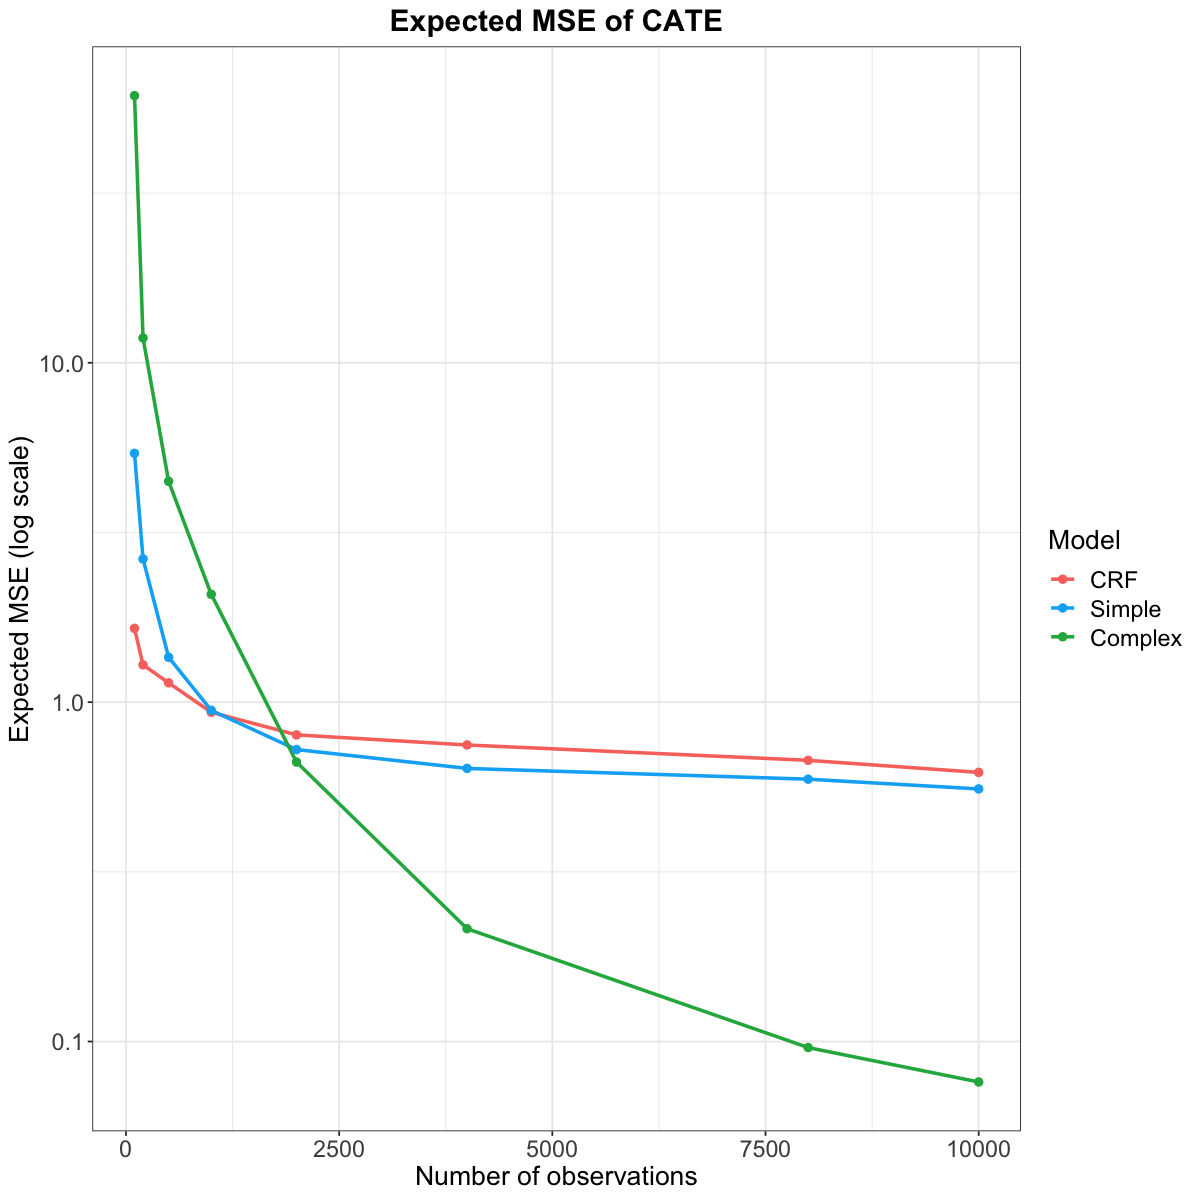

In [16]:
### CATE Results Graphs - Simulation Study 1 (Observations) 

# Generate datasets for graphs

graph_CATE_EMSE <- dataset_graph(data=Table_CATE_obs,vars=c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"))
graph_CATE_sd <- dataset_graph(data=Table_CATE_obs,vars=c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"))

options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=graph_CATE_EMSE,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="Expected MSE (log scale)",title="Expected MSE of CATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

**Figure 4 - ATE Results of Simulation Study 1**

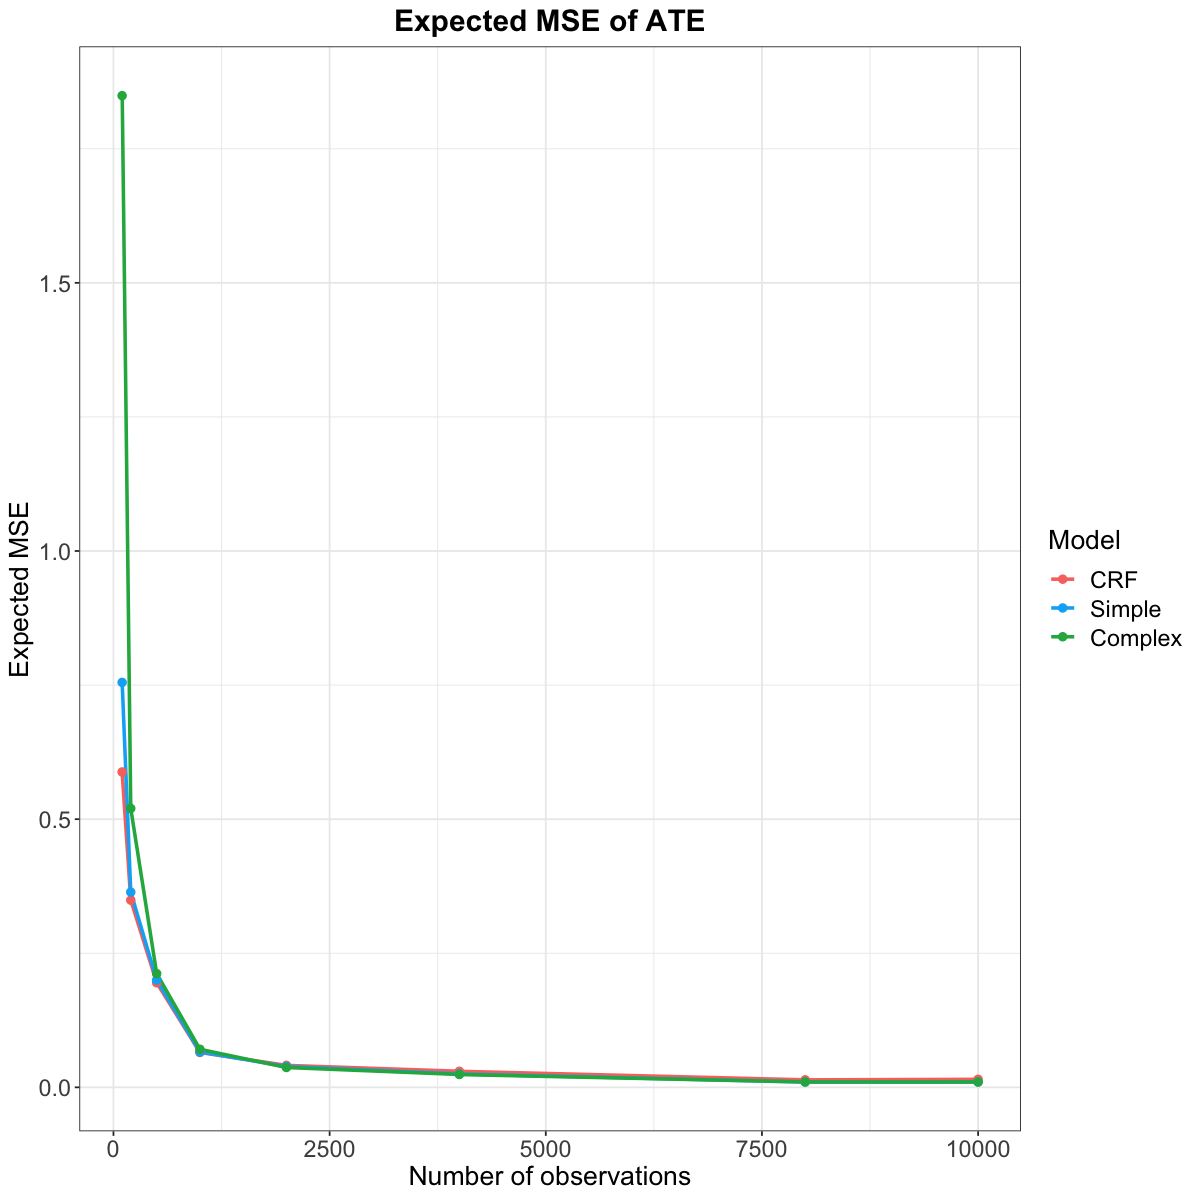

In [17]:
### ATE Graphs - Simulation Study 1 (Observations) 

# Generate datasets for graphs

graph_ATE_EMSE <- dataset_graph(data=Table_ATE_obs,vars=c("EMSE_ATE_crf","EMSE_ATE_simple","EMSE_ATE_complex"))

options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=graph_ATE_EMSE,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="Expected MSE",title="Expected MSE of ATE") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

The results are summarized in Table 3 and graphically presented in Figure 3 (CATE) and Figure 4 (ATE). For Figure 3, I decided to use a logarithmic scale on the y-axis because the range of the results is large. <br>
Figure 3 shows the MSE of the CATE for the three models depending on the number of observations. It is very striking how much higher the EMSE of the complex linear model (green) is in small samples with less than 1,000 observations. It is not only higher than the CRF EMSE (red) but also much higher than the EMSE of the simple linear model (blue). This is not surprising. For small samples, the OLS estimates are very imprecise in both models. However, the complex model depends on more imprecise estimated parameters than the simple model. Accordingly, it is very sensitive to "outliers" in the test data. Interestingly, CRF performs very well already for small sample sizes. Its estimated CATE EMSE is only about 1.65 for a sample size of 100. However, larger data samples do not decrease the CRF EMSE much further. In contrast, the linear models and particularly the complex model become much better for larger samples. Since the complex model is exactly specified like the true model, its CATE EMSE converges to zero for many observations. As expected, this is not the case for the simple model, because it does not fully capture the treatment heterogeneity. Its EMSE CATE converges to a positive value for increasing $n$. On the other hand, in Figure 4 one can see that the EMSE of the ATE converges to zero for both linear models. This is not surprising, because both models fulfill the OLS assumptions and particularly do not omit any relevant variables.<br>
For 2000 observations and above, both the complex and simple model perform better than CRF in estimating CATE and the ATE. The dominance of the complex linear model for large samples is clear: it is designed for capturing linear relationships between variables while CRF as a tree-based method is not. However, it is very surprising that the misspecified simple model has a lower CATE EMSE than the CRF. Although the difference is pretty small, it should be taken serious though. Eventually, the methods are compared for the same randomly drawn samples. Furthermore, Figure 4 suggests that the CRF is a little bit biased. The EMSE estimates are even slightly higher for 10,000 observations than for 7,500. A reasonable explanation therefore is that the CRF used in the simulation study is not optimally tuned yet. As described in section 2, the CRF algorithm can be adjusted for numerous parameters. The <code>causal_forest</code> function from the <code>grf</code> package has an <code>tune_parameters</code> option for parameter tuning via cross-validation. Since cross-validation is very computationally intensive, I disabled this option in the previous simulation study. Still, getting an idea about the value of parameter tuning, I run again the simulation for 10,000 observations and tune the parameters this time. The results are presented in the following table.

In [18]:
### Results of CRF with parameter tuning

set.seed(123)
results_obs_crf_tuned <- crf_sim_obs(n_obs=c(100,10000), m_runs=50,dgp_complex=T,parameter_tuning=TRUE)
set.seed(123)
results_obs_ols_tuned <- ols_sim_obs(n_obs=c(100,10000), m_runs=50,dgp_complex=T)

test =rbind(results_obs_crf_tuned,results_obs_ols_tuned)
test$"100"=NULL

100

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

10000

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

100

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

10000

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50



,10000
,<dbl>
EMSE_CATE_crf,0.404494266
MSE_CATE_crf_sd,0.096521841
EMSE_ATE_crf,0.010264387
MSE_ATE_crf_sd,0.016020948
EMSE_CATE_simple,0.554619723
MSE_CATE_simple_sd,0.085369340
EMSE_CATE_complex,0.076073979
MSE_CATE_complex_sd,0.041764095
EMSE_ATE_simple,0.010090159


In [26]:
test

,10000
,<dbl>
EMSE_CATE_crf,0.404494266
MSE_CATE_crf_sd,0.096521841
EMSE_ATE_crf,0.010264387
MSE_ATE_crf_sd,0.016020948
EMSE_CATE_simple,0.554619723
MSE_CATE_simple_sd,0.085369340
EMSE_CATE_complex,0.076073979
MSE_CATE_complex_sd,0.041764095
EMSE_ATE_simple,0.010090159


As one can see, indeed the EMSE of both the CATE and ATE decrease after tuning. With tuning, CRF also seems to perform better than the simple model but still performs worse than the complex model. This is exactly what I expected previously. However, the difference between CRF and the simple model is still pretty small. This is probably the case because the simple model only ignores a part of the treatment heterogeneity which is negligible anyway. If for instance the effect of the interaction term $\textit{high} \times \textit{prior} \times \textit{prior_squ}$ would be larger, the CATE EMSE of the simple model should be much larger. 

In [19]:
#Summing up, the results of the first simulation studies support my prior hypotheses. As expected, the linear models perform considerably worse than CRF in 

### 4.4 Simulation Study: High-dimensional Data <a name="sim_highdim"></a>

In the second simulation study, I will vary the number of dimensions while holding the number of observations fixed. In doing so, I add $k$ additional covariates denoted by $W_{j}$ that determine *stockret*. Hence, the new *stockret* variable $\textit{stockret}_{\textit{noise}}$ is composed as follows:

$(9) \qquad \textit{stockret}_{\textit{noise}} = \widehat{\textit{stockret}} + \mathbf{W}\mathbf{\gamma}$

whereby $\mathbf{W}$ is a matrix with dimension $n \times k$ that contains all $W_{j}$ and $\mathbf{\gamma}$ is the according parameter vector. The variable $\widehat{\textit{stockret}}$ is specified as in equation (3). Hence, the new dimension of the sample is $p+1+k$. Furthermore, it is necessary to determine the values of $\mathbf{\gamma}$ and the distribution of $\mathbf{W}$. For simplicity, I decided to draw W for each observation from a standard multivariate normal distribution. This means, the mean vector is the zero vector and the correlation matrix is the identity matrix. As a consequence, the noise variables are not correlated. Furthermore, I draw the $\mathbf{\gamma}$ from a uniform distribution ranging from -1 to 1. Hence, for $k$ large enough, the effect of the noise variables on stockret is zero. Note that the $\mathbf{\gamma}$ vector is only drawn randomly before the simulation study begins. Like the $\beta$ parameters, the values of $\mathbf{\gamma}$ are fixed fixed during the simulation study. <br>
I run the second simulation study with the functions <code>crf_sim_noise</code> and <code>ols_sim_noise</code>, which are similiar to those of the first simulation study. The number of repetitions $m$ is again 50. I fix the number of observations at 1,000. A larger number of observations would be better, but very costly regarding the computational time. Hence I decided to take the smallest number of observations for which all three methods previously performed sufficiently well. The vector assigned to the parameter <code>n_noise_vec</code> specifies for which numbers of noise variables $k$ the models are estimated. Note that the corresponding vector of the <code>crf_sim_noise</code> function contains three more elements: 1,500, 3,000, and 5,000. This makes it possible to study how the CRF performs in high-dimensional datasets. As derived in section 4.1, the OLS estimator can not be applied in this setting.  

In [20]:
### Set up noise variables

n_noise = 20
N = 1000

set.seed(123)
gamma_true_val = runif(n=6000,-1,1)
Sigma_noise_val = diag(6000)

In [21]:
### Simulation study with CRF

set.seed(123)
results_noise_crf = crf_sim_noise(n_noise_vec=c(10,50,100,200,500,750,900,950,980,1500,3000,5000),m=50,dgp_complex=T,n_obs=1000)

10

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

50

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

100

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

200

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

500

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

750

1

2

3

4

5

6


In [22]:
### Simulation study with linear model

set.seed(123)
results_noise_ols = ols_sim_noise(n_noise_vec=c(10,50,100,200,500,750,900,950,980),m=50,dgp_complex=T,n_obs=1000)

10

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

50

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

100

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

200

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

500

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

750

1

2

3

4

5

6


**Table 5 - Results of Simulation Study 2**

In [23]:
# Prepare summary tables 

results_noise_crf <- data.frame(results_noise_crf)
names(results_noise_crf) <- results_noise_crf["Noise",]
results_noise_crf <- t(results_noise_crf)

results_noise_ols <- data.frame(results_noise_ols)
names(results_noise_ols) <- results_noise_ols["Noise",]
results_noise_ols <- t(results_noise_ols)

results_noise <- merge(x=results_noise_crf,y=results_noise_ols,all=TRUE)
results_noise <- data.frame(t(results_noise))
names(results_noise) <- results_noise["Noise",]

### Table with CATE EMSE results for different dimensions

Table_CATE_noise = round(results_noise[c("EMSE_CATE_crf","MSE_CATE_crf_sd","EMSE_CATE_simple","MSE_CATE_simple_sd","EMSE_CATE_complex","MSE_CATE_complex_sd"),],3)
Table_CATE_noise

### Table with ATE EMSE results for different dimensions

Table_ATE_noise = round(results_noise[c("EMSE_ATE_crf","MSE_ATE_crf_sd","EMSE_ATE_simple","MSE_ATE_simple_sd","EMSE_ATE_complex","MSE_ATE_complex_sd"),],3)
Table_ATE_noise

,10,50,100,200,500,750,900,950,980,1500,3000,5000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_CATE_crf,1.176,1.338,1.471,1.744,2.036,2.145,2.371,2.504,3.007,4.282,6.010,7.653
MSE_CATE_crf_sd,0.187,0.203,0.354,0.566,1.056,1.155,1.453,1.489,2.245,5.332,4.744,6.052
EMSE_CATE_simple,0.914,0.972,0.965,0.978,1.384,2.267,5.030,9.155,48.045,NA,NA,NA
MSE_CATE_simple_sd,0.320,0.289,0.401,0.301,0.552,1.274,2.692,5.223,42.008,NA,NA,NA
EMSE_CATE_complex,2.092,2.274,2.361,2.907,4.931,6.616,14.153,48.006,410.300,NA,NA,NA
MSE_CATE_complex_sd,3.547,4.211,4.276,6.108,10.358,8.965,14.993,93.199,516.401,NA,NA,NA


,10,50,100,200,500,750,900,950,980,1500,3000,5000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_ATE_crf,0.081,0.120,0.238,0.482,0.740,0.824,1.011,1.156,1.664,2.992,4.536,6.194
MSE_ATE_crf_sd,0.102,0.153,0.310,0.555,1.080,1.151,1.377,1.511,2.233,5.552,4.707,6.179
EMSE_ATE_simple,0.070,0.069,0.066,0.073,0.160,0.370,0.979,1.807,8.492,NA,NA,NA
MSE_ATE_simple_sd,0.133,0.095,0.106,0.098,0.271,0.838,1.460,2.332,14.357,NA,NA,NA
EMSE_ATE_complex,0.074,0.079,0.071,0.088,0.169,0.363,0.940,1.715,24.463,NA,NA,NA
MSE_ATE_complex_sd,0.120,0.097,0.107,0.108,0.256,0.716,1.259,2.538,35.878,NA,NA,NA


**Figure 5 - CATE Results of Simulation Study 2**

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


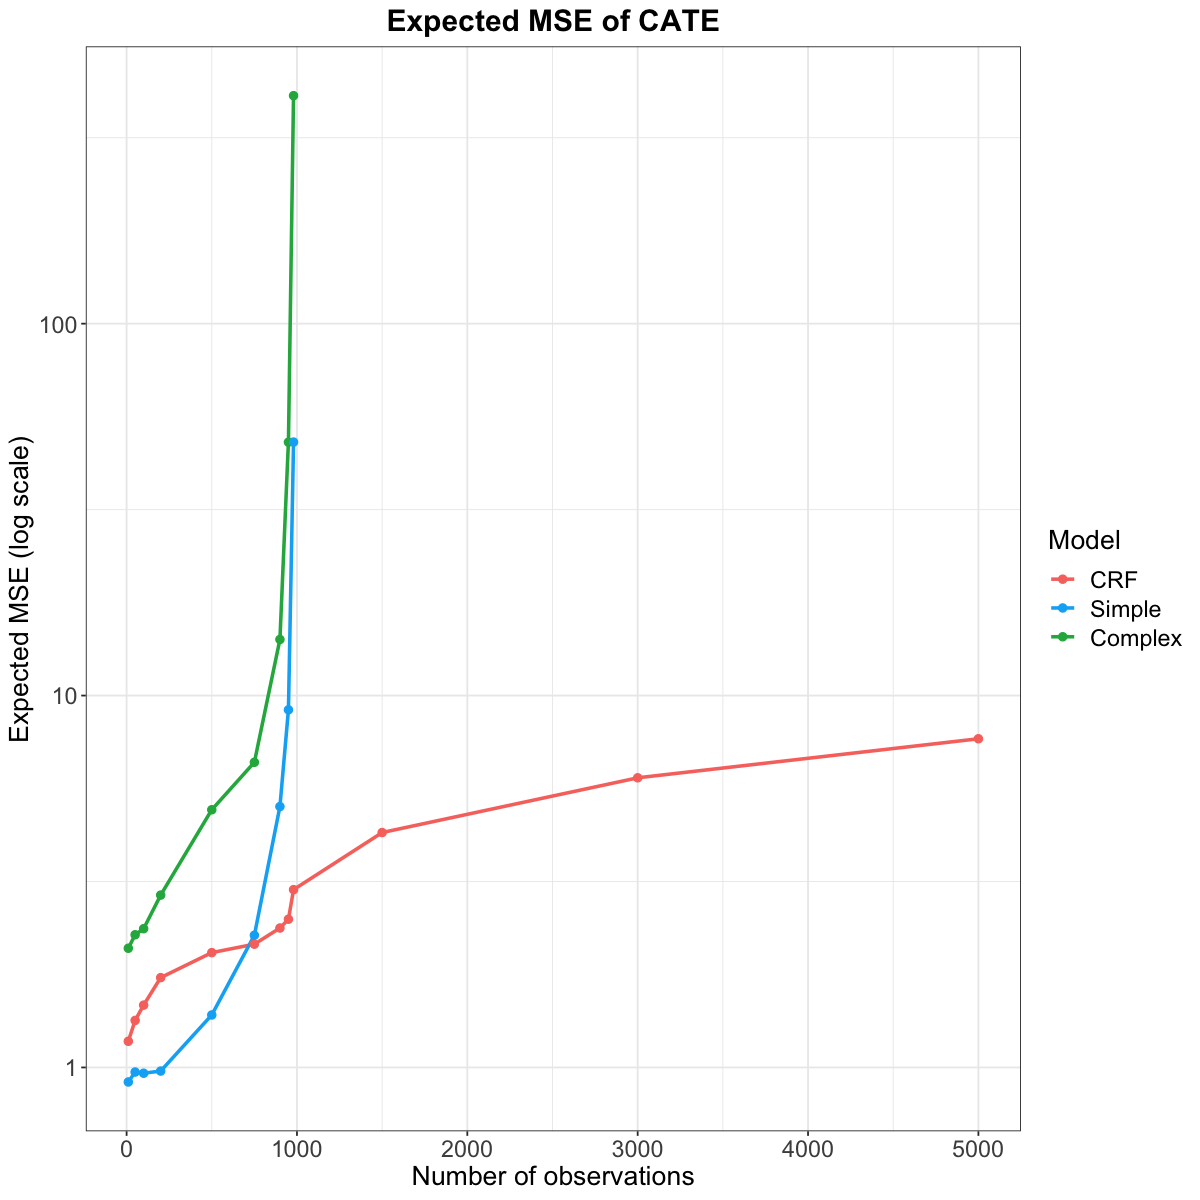

In [24]:
graph_CATE_EMSE_noise <- dataset_graph(data=Table_CATE_noise,vars=c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"))
graph_CATE_sd_noise <-dataset_graph(data=Table_CATE_noise,vars=c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"))

ggplot(data=graph_CATE_EMSE_noise,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="Expected MSE (log scale)",title="Expected MSE of CATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

**Figure 6 - ATE Results of Simulation Study 2**

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


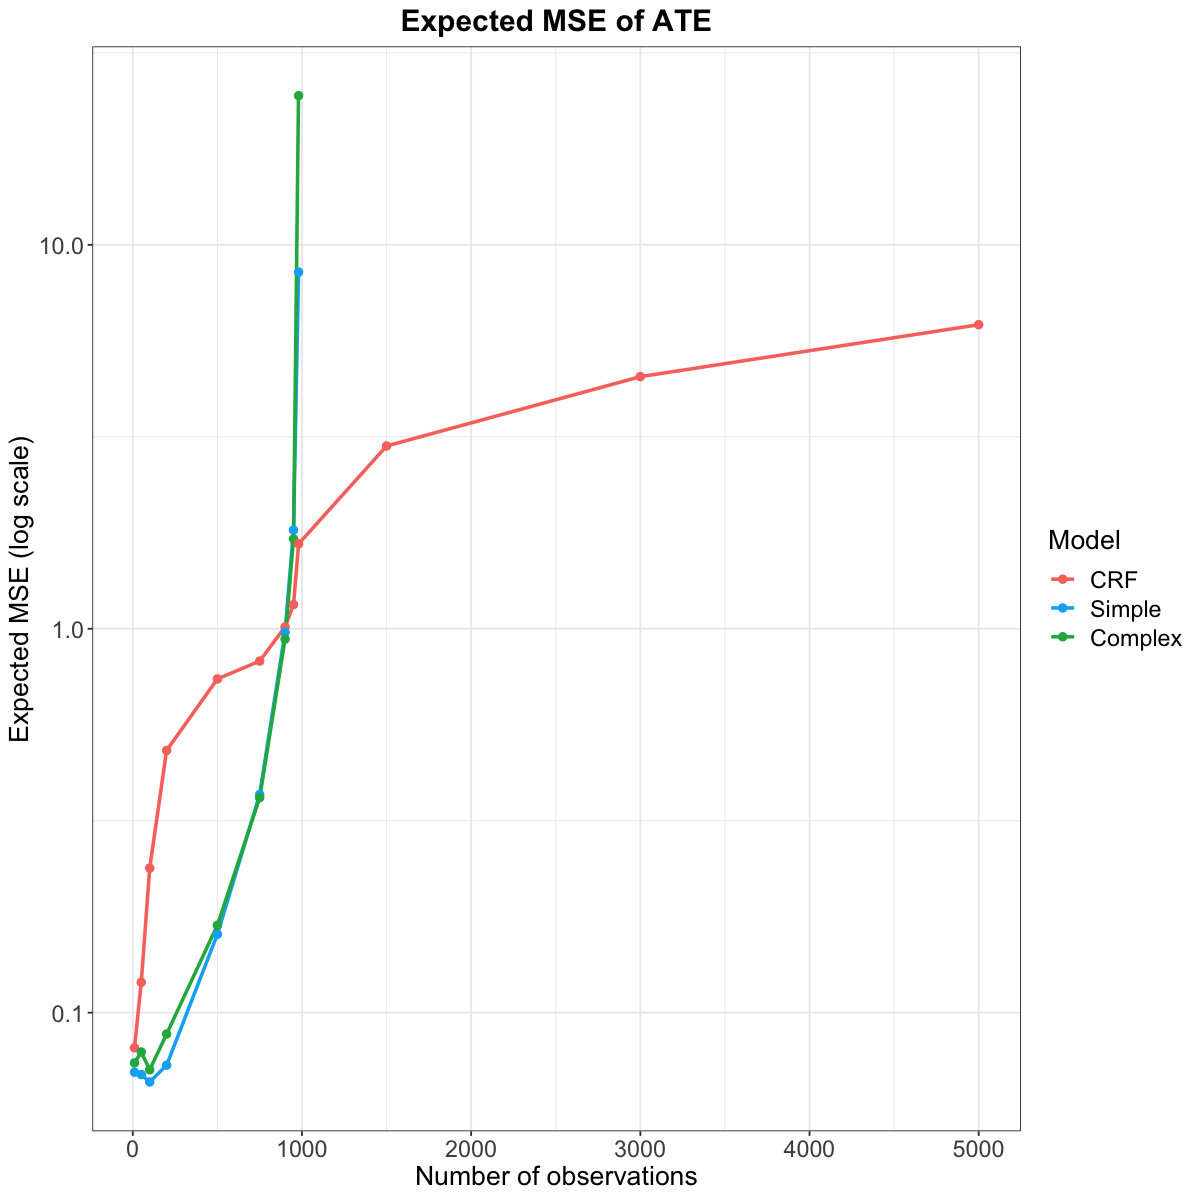

In [25]:
graph_ATE_EMSE_noise <- dataset_graph(data=Table_ATE_noise,vars=c("EMSE_ATE_crf","EMSE_ATE_simple","EMSE_ATE_complex"))

ggplot(data=graph_ATE_EMSE_noise,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="Expected MSE (log scale)",title="Expected MSE of ATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 


The results are summarized in Table 5 and graphically presented in Figure 5 (EMSE and standard deviation of CATE) and Figure 6 (EMSE of ATE). In both figures, I use a logarithmic scale on the y-axis. <br>
The two figures reveal a very interesting pattern. Both linear models can deal with a moderate number of noise variables very well. For 200 noise variables, both linear models predict the ATE nearly as good as without noise (see Figure 6). For this noise level, also the CATE estimations are as good as before for the simple model and only slightly worse for the complex model (see Figure 5). In contrast, the CATE and especially ATE EMSE of the CRF already increases significantly for few noise variables. Particularly, the increase in this range is higher than for the complex model. However, for $k$ larger than 200, the pattern changes. Now, the linear models become much more imprecise while CRF remains pretty accurate. Whereas the accuracy of CRF depends not substantially on whether 500 or 950 noise variables are added, the effect on the linear models is tremendous. **If $k$ increases from 10 to 950, the CATE EMSE of the simple model increases by a factor of 5 and the CATE EMSE of the complex model by a factor of 24 (see Table 5). In contrast, the CRF CATE EMSE only doubles.** The bad performance of the linear models is not surprising. As derived in subsection 4.1, if the number of observations is not much higher than the number of dimensions, the OLS estimator starts to become imprecise due to multicollinearity. Following the argumentation of the first simulation study, the imprecise estimates harms the accuracy of the complex model more. Furthermore, since by construction the complex model contains more covariates than the simple model, it has to handle more dimensions anyways. This effect becomes more severe the closer the number of dimensions is to the number of observations. Interestingly, a similar effect can be observed for CRF. There is a sharp increase of the EMSEs close to 980. When 980 noise variables are added, the number of dimensions is basically equal to the number of observations. Hence, it is not possible to check the OLS results for more than 980 noise variables. It is possible to do so for CRF, because the method is applicable in high-dimensional settings. The EMSE seems to increase moderately with decreasing slope if more than 980 variables are added. <br>
The practical lessons that can be drawn from this simulation study is ambigous and highly depends on the situation. 
Clearly, whenever the number of dimensions is just below the number of observations, one should refrain from using a linear model. If the number of noisy variables small, the simulation study implies that a not too complex linear model should be preferred. This is especially the case, if the researcher is interested in estimating the ATE. CRF enables the researcher to estimate CATE and ATE in high-dimensional datasets, which is not possible with OLS. Thereby, one has to keep in mind that also the CRF estimations may be imprecise if the signal-to-noise ratio is too low. <br>
However, note that the results of the simulation study are limited. First, the simulation assumed that the noise variables are uncorrelated by design. One can easily implement correlation by replacing the identity matrix in the simulation study functions by another positive semi-definite matrix. A correlation between the covariates increases the multicollinearity problematic, which complicates precise estimations for CRF and OLS. Furthermore, due to compuatation time, I did not further improve the CRF algorithm by tuning parameters via cross-validation. 

# 5. Conclusion <a name="conclusion"></a>

The results of the simulation studies mostly meet my expectations as stated in the hypotheses (see subsection 4.1). A very important results is, that causal forests outperform linear models for small sample sizes. This has great practical relevance. For instance, in many medical studies only few people with many characteristics are observed. In these settings, CRF can be a powerful tool for estimating the CATE. The same applies to situations with high-dimensional data, where researchers can use CRF while linear models are not available. <br>
Independent from the underlying data sample, it is another great advantage of CRF that it does not depend on a model specification. It was my intention to emphasize this by comparing CRF with a misspecified model. Since the simple model only ignored a pretty unimportant part of treatment heterogeneity in my example, this feature remained rather hidden. In other settings though, the independence of specification can be a major advantage of CRF. Note that the linear model could only outperform CRF in the first simulation study for sufficiently large datasamples, if the model is correctly specified. This can be easily achieved in a simulation study in which the relationship between the outcome and the independent variables is known. However, in practice the linear model usually will never be exactly correctly specified. This is especially the case, if the outcome does not dependent linearly on the explaining variables. <br>
Despite the many advantages, CRF also has some limitations. Most importantly, it must assume unconfoundedness. Thus, it can be primarily used in experimental rather than observational settings. Additionally, my second simulation study revealed that CRF performs worse already when a few further covariates are added. Another minor disadvantage of CRF is that the method requires much compuation power. This is especially the case when parameter tuning with cross-validation is enabled. **Despite that, the addition to my first simulation study showed that generally the CRF parameters should be tuned to improve the performance of the method further.** <br>
My work shed light on how CRF deals with different types of datasets compared to the linear model. Needless to say, there are many other important aspects that can be studied in further simulation studies. For example, I did not consider the confidence intervalls of the CRF estimates that are needed for causal inference. Moreover, it would be very interesting to study how the CRF results are biased when the unconfoundedness assumption is not fulfilled.

# 6. Bibliography <a name="bib"></a>